# Computer-assisted drug discovery
###### Zoë Vergouwe, Misha Zekveld, Valeria Montijn, Julia Kersting, Rinus Verhoef, Joanne van den Bergh, Annefleur van Will, Lilian van Stokkum
###### Group 14
Computer-assisted drug discovery (CADD) is a rapidly growing field that involves the use of computational approaches in the discovery and design of small-molecule drugs. in this code  kinase inhibitors are identified that selectively target a specific kinase while minimizing off-target effects. the two inhibitors are Pyruvate kinase type M2 (PKM2) and Extracellular signal-Regulated Kinase 2 (ERK2). Molecules that are tested based of descriptors if they can inhibit or not and are graded on this to find the best inhibiting moelcules to test in the lab, minimizing false positives and false negatives.
#### Layout:
- Importing libraries
- Opening files
- Scaling and PCA
- Data boxplots
- Train_test_split
- GridSearchCV
- Accuracy
- Confusion Matrices
- Scores
- Untested molecules
## Importing libraries

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import random

sns.set()
plt.rcParams['figure.figsize'] = 7,5  # Default size of plots
plt.rcParams['lines.markeredgewidth'] = 1  # Fix issue with seaborn box plots; needed 

## Opening files
Splits the files so it doesn't take the first column of SMILES and splits the target inhibition columns

In [18]:
df_results = pd.read_csv('Data/tested_molecules.csv')
df_mpg = pd.read_csv('Data/data_descriptors.csv')

# Prepare the features and target
features = df_mpg.columns[1:]
X = df_mpg[features]
y = df_results['PKM2_inhibition']
y1 =df_results['ERK2_inhibition']
# Drop feautures with only 0 values
X = X.dropna(axis=1, how='all')

      MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0              5.313889        5.313889           0.120833        0.120833   
1             11.238954       11.238954           0.225308       -0.366756   
2             11.090706       11.090706           0.049610       -0.049610   
3             11.892238       11.892238           0.076632       -0.457824   
4             11.693580       11.693580           0.012315       -0.498260   
...                 ...             ...                ...             ...   
1111          12.955843       12.955843           0.016627       -0.290408   
1112          12.983770       12.983770           0.009487       -3.772852   
1113          10.579691       10.579691           0.249681        0.249681   
1114           4.812249        4.812249           0.983396        0.983396   
1115           4.773662        4.773662           0.662326        0.662326   

           qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt 

## Scaling and PCA
After which a figure of the cumulative explained variance is plotted


17


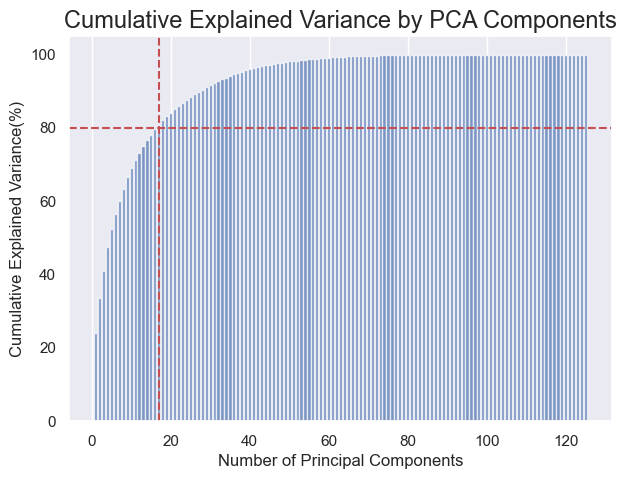

In [6]:
scaler =MinMaxScaler() 
X_scaled = scaler.fit_transform(df_mpg[features]) # Scale the features data

pca = PCA()  # Perform PCA for only the X data
X_pca = pca.fit_transform(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_) # Get the cumulative explained variance
num_components = np.argmax(cumulative_variance >= 0.8) + 1 # Number of components that captures at least 80% variance

plt.figure() # Plot a histogram of the cumulative explained variance
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance*100, alpha=0.7, align='center')
plt.axhline(y=80, color='r', linestyle='--') # Get the y point where it is 80%
plt.axvline(x=num_components, color='r', linestyle='--') # Get the x point for 80%
plt.title('Cumulative Explained Variance by PCA Components', fontsize='17')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance(%)')
plt.grid(axis='y')

print(num_components)

## Data boxplots
Two boxplots showcasing the difference between the scaled and unscaled data

Text(0.5, 1.0, 'MinMax Scaled Data')

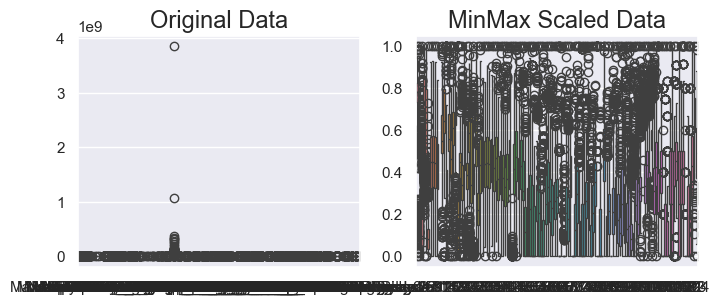

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3)) 
sns.boxplot(data=X, ax=axs[0])
sns.boxplot(data=X_scaled, ax=axs[1])

axs[0].set_title('Original Data', fontsize='17') 
axs[1].set_title('MinMax Scaled Data', fontsize='17')

## Train_test_split
First performs PCA on the selected components and splits them into test and train data

In [8]:
pca = PCA(n_components=num_components) # Only use the components that make up the 80% variance
X_pca_selected = pca.fit_transform(X_scaled)

pca_columns = [f"PC{i+1}" for i in range(num_components)]
df_pca_selected = pd.DataFrame(X_pca_selected, columns=pca_columns) # Put it into a dataframe

# Split the data
X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(df_pca_selected, y, test_size=0.2, random_state=42)
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(df_pca_selected, y1, test_size=0.2, random_state=42)

## GridSearchCV
First gets the logistic regression and uses GridSearchCV, which is a technique to search through the best parameter values from the given set of the grid of parameters, to get the best parameters

In [9]:
lr = LogisticRegression(class_weight='balanced', random_state=42) # Classifier 

# Set possible parameters for the gridsearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga'],  # 'liblinear' for l1 and l2, 'saga' for elasticnet
    'max_iter': [100, 500, 1000, 1500, 2000]
}

grid_search_E = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1) # Gridsearch for both inhibitors
grid_search_P = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_E.fit(X_train_E, y_train_E) # Refit it
grid_search_P.fit(X_train_P, y_train_P)

print(f"Best parameters: {grid_search_P.best_params_}") # Show best parameters
print(f"Best score: {grid_search_P.best_score_}") # Show best score
print(f"Best parameters: {grid_search_E.best_params_}")
print(f"Best score: {grid_search_E.best_score_}")

best_model_P = grid_search_P.best_estimator_ # Evaluate the model based on the test set
best_model_E = grid_search_E.best_estimator_
y_pred_P = best_model_P.predict(X_test_P) 
y_pred_E = best_model_E.predict(X_test_E)


C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCac

Best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.7750574712643677
Best parameters: {'C': 100, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.6733034135726913


C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCac

## Accuracy
Calculates the accuracy. First the non-weighted accuracy, with our balanced dataset, then the weighted accuracy. 

In [10]:
accuracy_E = accuracy_score(y_test_E, y_pred_E)
print(f'Accuracy_E: {accuracy_E}')
accuracy_P = accuracy_score(y_test_P, y_pred_P)
print(f'Accuracy_P: {accuracy_P}')

balanced_accuracy_E = balanced_accuracy_score(y_test_E, y_pred_E) # Weighted accuracy ERK2
print(f"The weighted accuracy_E of the lr model is: {balanced_accuracy_E}")

balanced_accuracy_P = balanced_accuracy_score(y_test_P, y_pred_P) # Weighted accuracy PKM
print(f"The weighted accuracy_P of the lr model is: {balanced_accuracy_P}")

cv_scores_P = cross_val_score(lr, X_scaled, y, cv=5, scoring="balanced_accuracy") # CV scores
print(f"The Cross-validation scores for PKM2 are: {cv_scores_P}")
print(f"The mean Cross-validation score for PKM2 is: {cv_scores_P.mean()}")

cv_scores_E = cross_val_score(lr, X_scaled, y1, cv=5, scoring="balanced_accuracy") # CV scores
print(f"The Cross-validation scores for ERK2 are: {cv_scores_E}")
print(f"The mean Cross-validation score for ERK2 is: {cv_scores_E.mean()}")


Accuracy_E: 0.6785714285714286
Accuracy_P: 0.7633928571428571
The weighted accuracy_E of the lr model is: 0.5384615384615384
The weighted accuracy_P of the lr model is: 0.8784403669724771
The Cross-validation scores for PKM2 are: [0.79892966 0.78073394 0.64266055 0.88210445 0.6624424 ]
The mean Cross-validation score for PKM2 is: 0.7533742020039741
The Cross-validation scores for ERK2 are: [0.55420401 0.43802817 0.65375587 0.59671362 0.67558685]
The mean Cross-validation score for ERK2 is: 0.5836577037985489


## Confusion Matrices
Generates plots that show any false negatives or positives in the above mentioned predicted data. Also show all rightly predicted inhibiton numbers

Text(0.5, 1.0, 'Confusion Matrix PKM2')

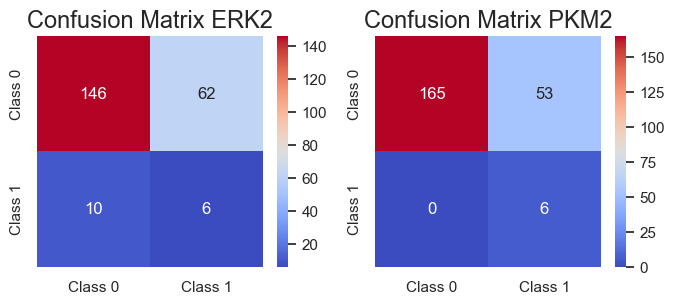

In [11]:
# Get confusion matrices
cm_E = confusion_matrix(y_test_E, y_pred_E)
cm_P = confusion_matrix(y_test_P, y_pred_P)

# Create figures
fig, axs = plt.subplots(1, 2, figsize=(8, 3) )
sns.heatmap(cm_E, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'],  ax=axs[0])
axs[0].set_title('Confusion Matrix ERK2', fontsize='17')

sns.heatmap(cm_P, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[1])
axs[1].set_title('Confusion Matrix PKM2', fontsize='17')

## Scores
Gets four scores for determining whether or not the given model is optimal: precision, recall, F1, and ROC AUC respectively, for both inhibitors. 

And lastly for both ERK2 and PKM2 the cross_validation scores are calculated because we are looking at real world data which is often distributed more unevenly, meaning the fitted model might perform better in some sections. In order to account for that uneven data, this score is also looked at.

In [12]:
# Scores for PKM2
precision_P = precision_score(y_test_P, y_pred_P) # Precision score
print(f"Precision Score: {precision_P}")
recall_P = recall_score(y_test_P, y_pred_P) # Recall score
print(f"Recall Score: {recall_P}")
f1_P = f1_score(y_test_P, y_pred_P) # F1 score
print(f"F1 Score: {f1_P}")
roc_auc_P = roc_auc_score(y_test_P, y_pred_P) # ROC AUC score
print(f"ROC AUC Score: {roc_auc_P}")


Precision Score: 0.1016949152542373
Recall Score: 1.0
F1 Score: 0.18461538461538463
ROC AUC Score: 0.8784403669724771


In [13]:
# Scores for ERK2
precision_E = precision_score(y_test_E, y_pred_E) # Precision score
print(f"Precision Score: {precision_E}")
recall_E = recall_score(y_test_E, y_pred_E) # Recall score
print(f"Recall Score: {recall_E}")
f1_E = f1_score(y_test_E, y_pred_E) # F1 score
print(f"F1 Score: {f1_E}")
roc_auc_E = roc_auc_score(y_test_E, y_pred_E) # ROC AUC score
print(f"ROC AUC Score: {roc_auc_E}")

Precision Score: 0.08823529411764706
Recall Score: 0.375
F1 Score: 0.14285714285714285
ROC AUC Score: 0.5384615384615384


## Untested molecules
Does the same steps as before: opens the file, scaling, PCA, fitting and predicting as done with the tested molecules.
Writes the prediction in a new results file

In [17]:
df_untested = pd.read_csv('Data/untested_molecules_descriptors.csv') # Opening data
features_u = df_untested.columns[1:]

scaler =MinMaxScaler() # Scaling
untested_scaled = scaler.fit_transform(df_untested[features_u])

pca_u = PCA(n_components=num_components) # PCA
X_pca_untested = pca.fit_transform(untested_scaled)

pca_columns_u = [f"PC{i+1}" for i in range(num_components)]
df_pca_u = pd.DataFrame(X_pca_untested, columns=pca_columns_u) # New dataframe

u_pred_P = best_model_P.predict(df_pca_u) # Predicted values
u_pred_E = best_model_E.predict(df_pca_u)

df_final = pd.DataFrame() # Final dataframe
df_final["SMILES"] = df_untested["SMILES"]
df_final["PKM2_inhibition"] = u_pred_P
df_final["ERK2_inhibition"] = u_pred_E

df_final.to_csv("results.csv", index=False)  # Put the dataframe inta an Excel file, index=False leave out the index in the file

0
